The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

In [83]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import random
import zCurve as z
import math

In [84]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def remove_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
       file_path = os.path.join(folder_path, filename)
       if os.path.isfile(file_path):
          os.remove(file_path)
          print(filename, "is removed")

In [85]:
def generate_trajectory(examplename="", speedchange=0, angle=-1, numexamples=5, fixed_speed=None, fixed_angle=None, num_points=2500):
    for example in range(1,numexamples+1):
        filename = "results/synthetic_lanechangecitos/"+examplename+"_"+str(example)+".csv"
        
        timestamp = 0
        delta_t = 10**4  # Time step in microseconds
        initial_speed = fixed_speed if fixed_speed else (30 - example * 2) 
        lanechange_progress = 0
        was_lane_change = 0
        steering_angle_amplitude = fixed_angle if fixed_angle else (20 + example * 3) 
        
        with (open(filename, mode='w', newline='') as file):
                writer = csv.writer(file, delimiter=';')
                writer.writerow(["Time (seconds)", "Time (microseconds)", "Speed (m/s)", "Steering angle (deg)", "Lane change"])
                
                for i in range(0, num_points):                    
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0 else 1
                    
                    if was_lane_change != islanechange: lanechange_progress = 0
                    elif islanechange: lanechange_progress += 1
                    
                    turning_angle = - math.sin(timestamp*delta_t/10**10) * (steering_angle_amplitude+example) * islanechange * angle
                    
                    was_lane_change = islanechange
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0.2 else 1
                    
                    speed = initial_speed + lanechange_progress / 40 * speedchange
                    
                    writer.writerow([int(timestamp / 1000000), timestamp % 1000000, speed, turning_angle, islanechange])
                    timestamp += delta_t
            


lcright_fixedspeed_2.csv is removed
lcleft_fixedmaxangle_speedup_2.csv is removed
lcright_fixedspeed_1.csv is removed
lcleft_fixedmaxangle_speedup_1.csv is removed
lcleft_fixedspeed_1.csv is removed
lcleft_fixedspeed_2.csv is removed
lcleft_fixedmaxangle_1.csv is removed
lcleft_fixedmaxangle_2.csv is removed
lcright_fixedmaxangle_1.csv is removed
lcright_fixedmaxangle_speedup_2.csv is removed
lcright_fixedmaxangle_2.csv is removed
lcright_fixedmaxangle_speedup_1.csv is removed
results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv


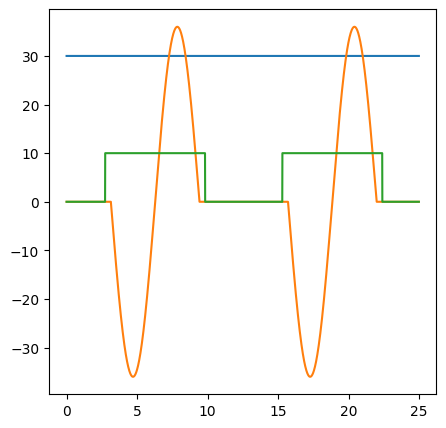

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_4.csv


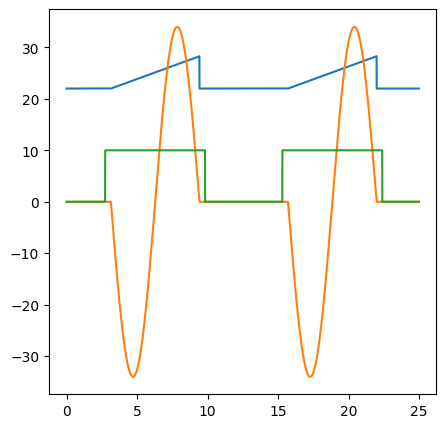

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_5.csv


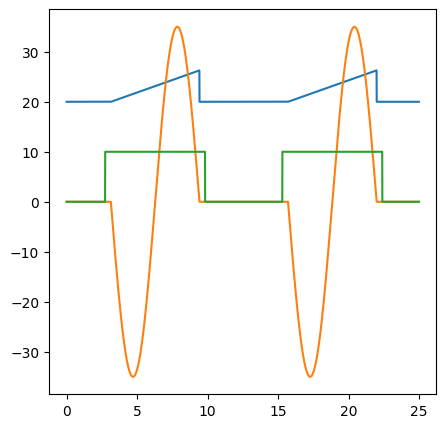

results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv


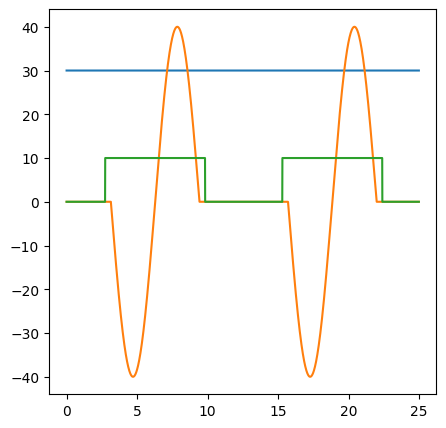

results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv


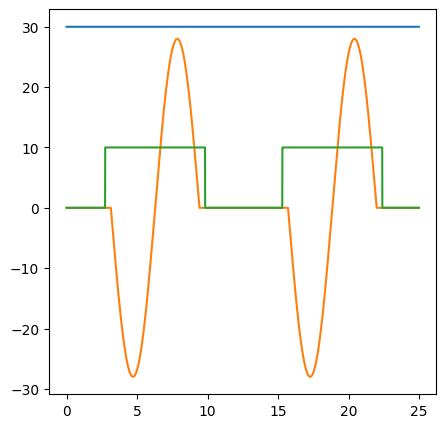

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_2.csv


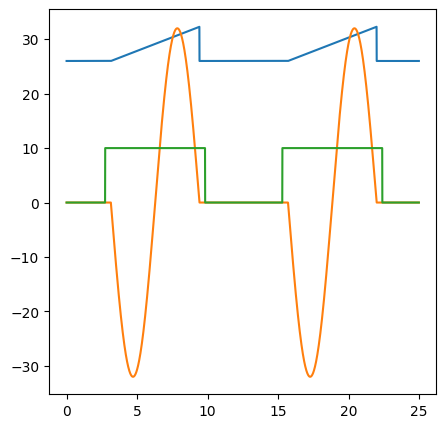

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_3.csv


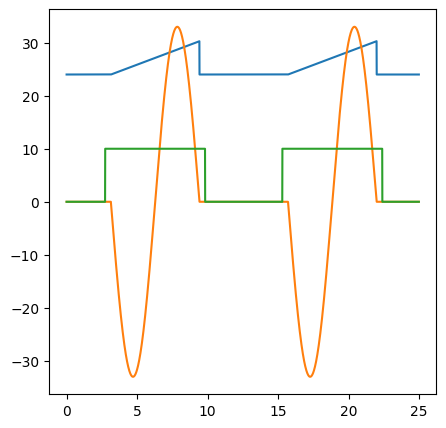

results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv


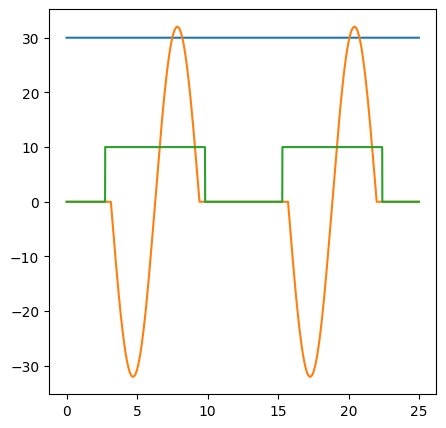

results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv


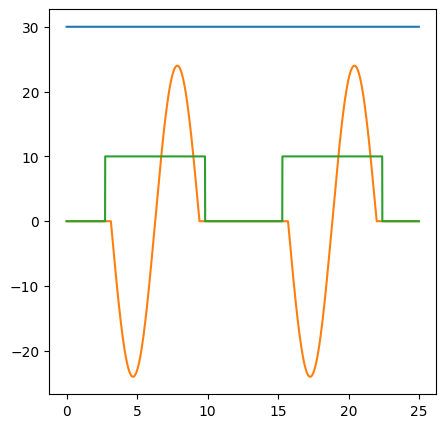

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_speedup_1.csv


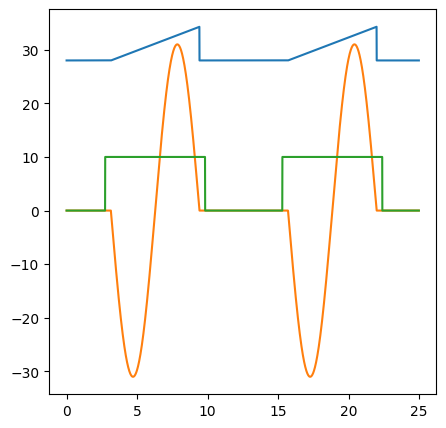

results/synthetic_lanechangecitos/lcleft_fixedspeed_1.csv


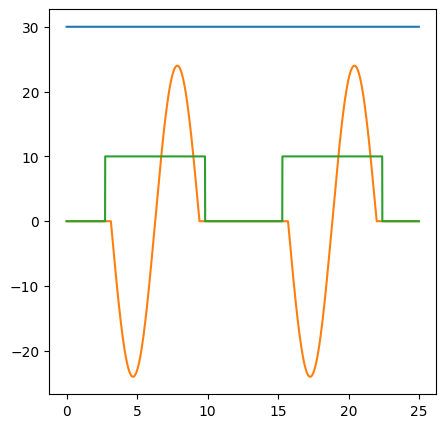

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_5.csv


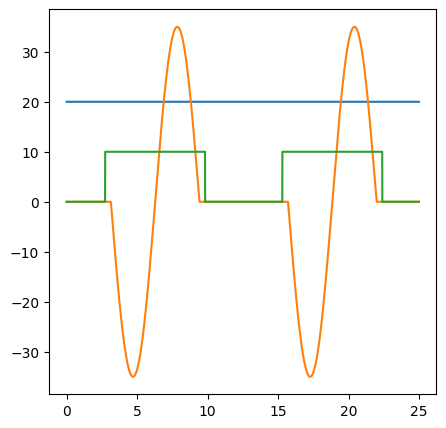

results/synthetic_lanechangecitos/lcleft_fixedspeed_3.csv


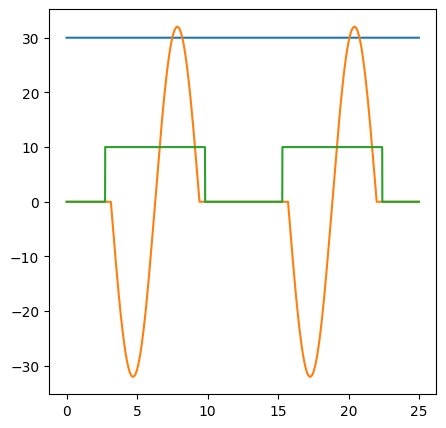

results/synthetic_lanechangecitos/lcleft_fixedspeed_2.csv


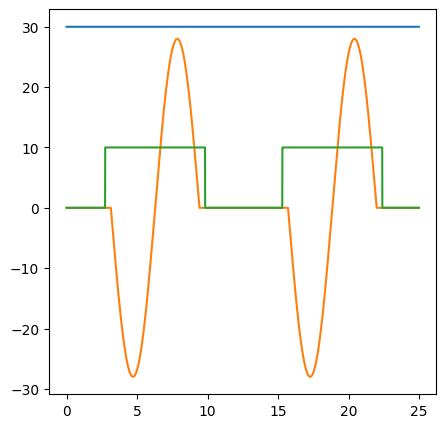

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_4.csv


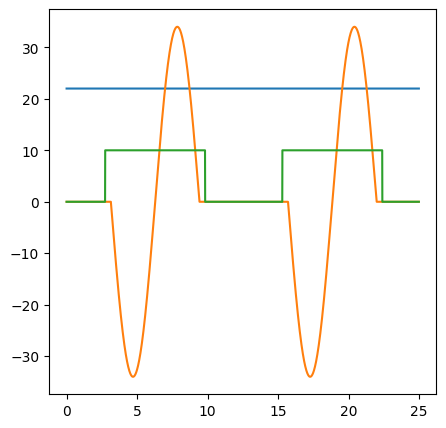

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_1.csv


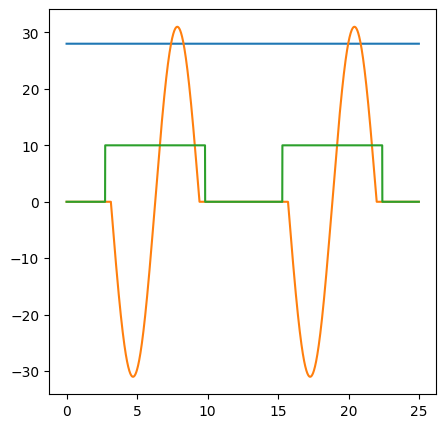

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_3.csv


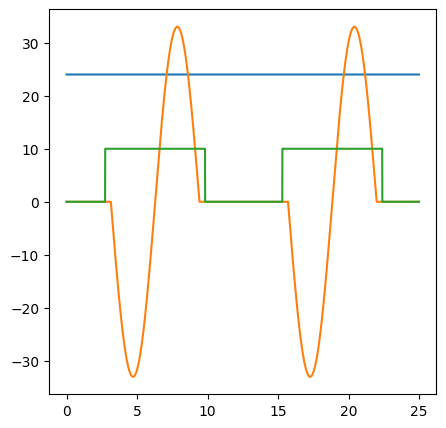

results/synthetic_lanechangecitos/lcleft_fixedspeed_5.csv


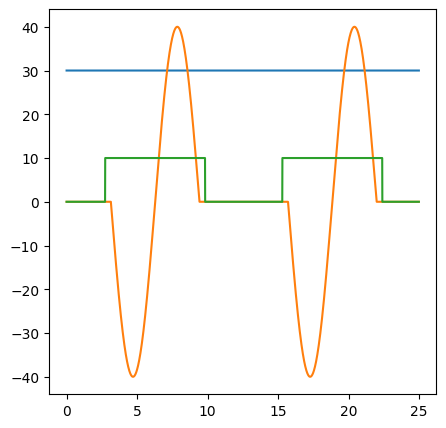

results/synthetic_lanechangecitos/lcleft_fixedspeed_4.csv


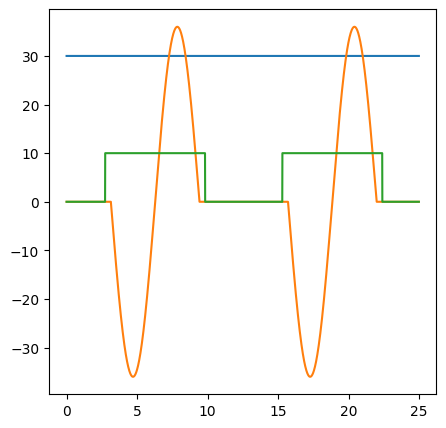

results/synthetic_lanechangecitos/lcleft_fixedmaxangle_2.csv


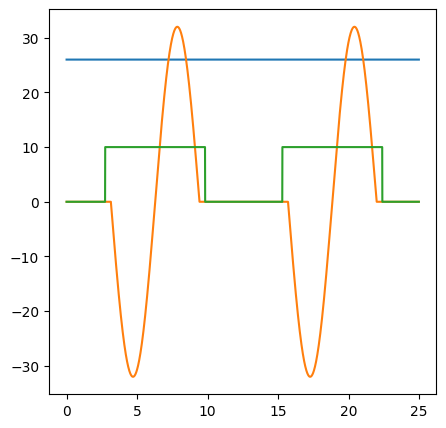

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv


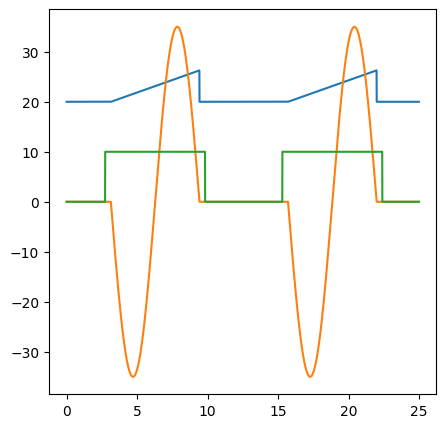

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv


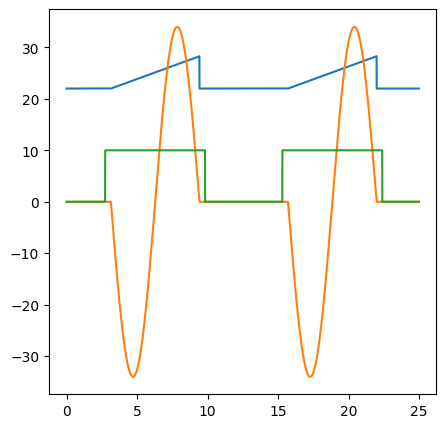

results/synthetic_lanechangecitos/lcright_fixedmaxangle_5.csv


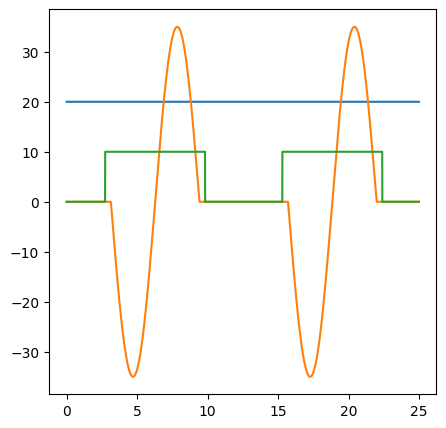

results/synthetic_lanechangecitos/lcright_fixedmaxangle_4.csv


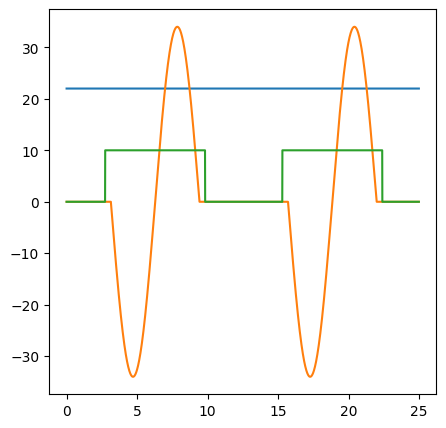

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv


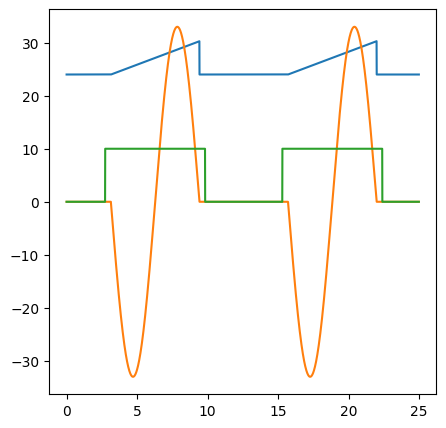

results/synthetic_lanechangecitos/lcright_fixedmaxangle_1.csv


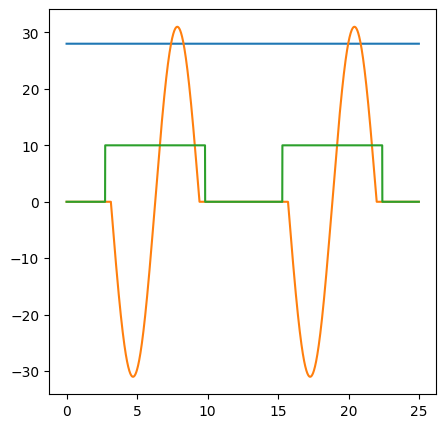

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv


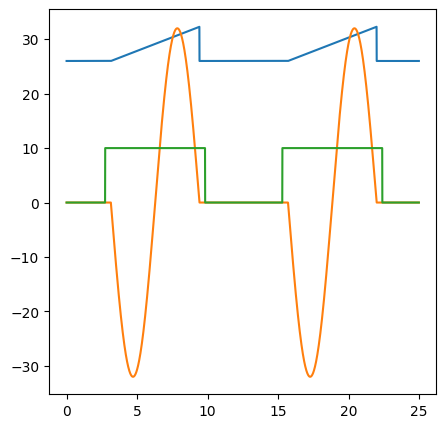

results/synthetic_lanechangecitos/lcright_fixedmaxangle_3.csv


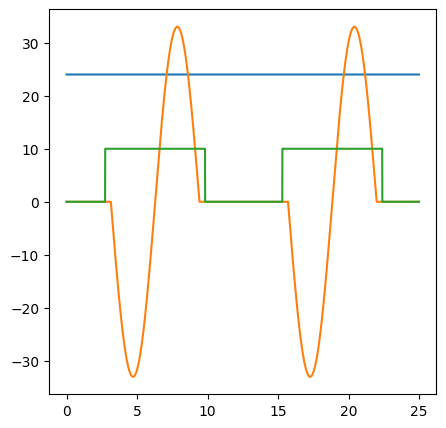

results/synthetic_lanechangecitos/lcright_fixedmaxangle_2.csv


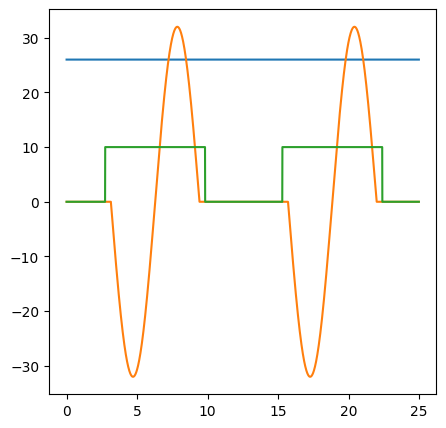

results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv


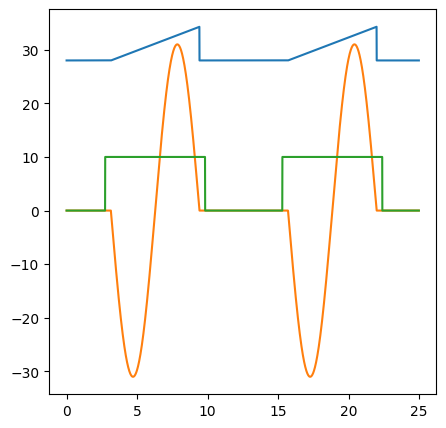

In [86]:
remove_files_in_folder("results/synthetic_lanechangecitos/")

for dir in ["left", "right"]:
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle", speedchange=0, angle=-1, fixed_angle=30)    
    generate_trajectory(examplename="lc"+dir+"_fixedspeed", speedchange=0, angle=-1, fixed_speed=30)
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle_speedup", speedchange=0.4, angle=-1, fixed_angle=30)    

for new_traj_name in get_files_in_folder("results/synthetic_lanechangecitos"):
    if not new_traj_name.endswith(".csv"):
        continue
    print(new_traj_name)
        
    file_basename = os.path.splitext(os.path.basename(new_traj_name))[0]
    data = pd.read_csv(new_traj_name, sep=';')    
    data['timestamp'] = data['Time (seconds)'] * 1_000_000 + data['Time (microseconds)']
    data['timestamp'] /= 1_000_000
    
    plt.figure(figsize=(5, 5))
    plt.plot(data['timestamp'], data["Speed (m/s)"], label='Speed')
    plt.plot(data['timestamp'], data["Steering angle (deg)"], label='Steering angle')
    plt.plot(data['timestamp'], data["Lane change"]*10, label='Lane change')
    plt.show()